In [1]:
import numpy as np
from loadMNIST import LoadMNIST
import matplotlib.pyplot as plt
%matplotlib inline

## A DIY classifier
In this notebook, we'll build a simple classifer to discriminate between 1's and 0's in the MNIST database.

First, we'll construct a simple 2D feature space by projecting digit images onto hand-selected 0 and 1 templates. 

We'll then design a linear classifier by hand, just by looking at the distribution of MNIST images in our simple feature space.

### The data
We'll use the MNIST dataset for this exercise. First we'll load up the images and normalize them.

In [68]:
##load all MNIST images, then select out the 0 and 1 images

mnist_trn_img = '/mnt/fast/MNIST/train-images-idx3-ubyte'
mnist_trn_lab = '/mnt/fast/MNIST/train-labels-idx1-ubyte'
mnist_val_img = '/mnt/fast/MNIST/t10k-images-idx3-ubyte'
mnist_val_lab = '/mnt/fast/MNIST/t10k-labels-idx1-ubyte'

mnist_trn_data = LoadMNIST(mnist_trn_img)
mnist_val_data = LoadMNIST(mnist_val_img)
mnist_trn_label = LoadMNIST(mnist_trn_lab)
mnist_val_label = LoadMNIST(mnist_val_lab)

trn_ones = mnist_trn_data[mnist_trn_label==1].astype('float32')
val_ones = mnist_val_data[mnist_val_label==1].astype('float32')

trn_zeros = mnist_trn_data[mnist_trn_label==0].astype('float32')
val_zeros = mnist_val_data[mnist_val_label==0].astype('float32')

>u1
(60000, 28, 28)
>u1
(10000, 28, 28)
>u1
(60000,)
>u1
(10000,)


there are 6742 ones and 5923 zeros in the training set
there are 1135 ones and 980 zeros in the validation set


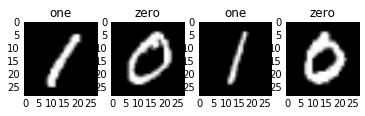

In [69]:
##sanity check
plt.subplot(1,4,1)
plt.imshow(trn_ones[0],cmap='gray')
plt.title('one')
plt.subplot(1,4,2)
plt.imshow(trn_zeros[0],cmap='gray')
plt.title('zero')
plt.subplot(1,4,3)
plt.imshow(val_ones[0],cmap='gray')
plt.title('one')
plt.subplot(1,4,4)
plt.imshow(val_zeros[0],cmap='gray')
plt.title('zero')

pixel_res = trn_ones.shape[1]
n_trn_ones = trn_ones.shape[0]
n_val_ones = val_ones.shape[0]
n_trn_zeros = trn_zeros.shape[0]
n_val_zeros = val_zeros.shape[0]

print 'there are %d ones and %d zeros in the training set' %(n_trn_ones,n_trn_zeros)
print 'there are %d ones and %d zeros in the validation set' %(n_val_ones,n_val_zeros)


It is generally a good idea to normalize the input data, so that feature space is not dominated by the "brightness" of images, but rather by their shape. To do this, we first subtract the mean from each image, then divide each image by it's magnitude

In [74]:
##normalize images
##note the use of np.newaxis to take advantage of broadcasting rules!
for arr in [trn_ones, trn_zeros, val_ones, val_zeros]:
    arr -= np.mean(arr,axis=(1,2))[:,np.newaxis,np.newaxis]  
    arr /= np.sqrt(np.sum(arr**2,axis=(1,2)))[:,np.newaxis,np.newaxis]

### The feature space
We'll construct a simple linear transform that maps each MNIST image into a point in a 2D feature space.

The axes of this feature space will correspond to a 0-template and a 1-template.

Select two images from the training data to be "templates"

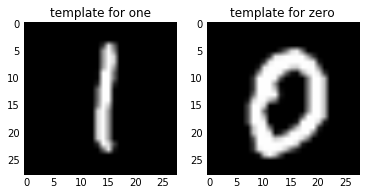

In [5]:
one_temp_idx = np.random.randint(0,high=n_trn_ones)    ##random template selection
zero_temp_idx = np.random.randint(0,high=n_trn_zeros)
one_temp = trn_ones[one_temp_idx]
zero_temp = trn_zeros[zero_temp_idx]

##view your templates
plt.subplot(1,2,1)
plt.imshow(one_temp,cmap='gray')
plt.title('template for one')
plt.subplot(1,2,2)
plt.imshow(zero_temp,cmap='gray')
plt.title('template for zero')

Let $\mathbf{t_0}$ be the zero template, and $\mathbf{t_1}$ be the one template. Let $\mathbf{s}$ be an image in the training set. Map all training data images (both zeros and ones) into the 2D feature space defined

$\phi(\mathbf{s}) = (\mathbf{s} \cdot \mathbf{t_0}, \mathbf{s} \cdot \mathbf{t_1})$

In [6]:
##first, we reshape the templates and stack them into a matrix
temps = np.array([zero_temp.ravel() , one_temp.ravel()]).T
print temps.shape

##next we project each of the images onto the templates
phi_s_ones = trn_ones.reshape((n_trn_ones,pixel_res**2)).dot(temps)
print phi_s_ones.shape

phi_s_zeros = trn_zeros.reshape((n_trn_zeros,pixel_res**2)).dot(temps)
print phi_s_zeros.shape


(784, 2)
(6742, 2)
(5923, 2)


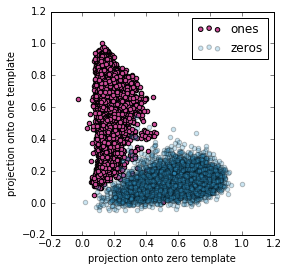

In [13]:
##view the projections, assigning different colors to each class
one_color = np.array([.8,.3,.6])  ##pink vector
zero_color = np.array([.2,.6,.8])  ##blue vector

plt.scatter(phi_s_ones[:,0], phi_s_ones[:,1],c=one_color,label='ones', alpha = 1)
plt.scatter(phi_s_zeros[:,0], phi_s_zeros[:,1],c=zero_color,label='zeros', alpha = 0.25)
plt.legend()
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel('projection onto zero template')
plt.ylabel('projection onto one template')

Not surprisingly, images of ones hug the "ones" axis, and images of zeros hug the "zeros" axis. Now let's try to hand-code a discriminant surface into this feature space that separates out the two classes of images.

### Hand-coding a classifier

In class we learned that linear discriminant functions:

$y(\mathbf{x}) = \mathbf{w} \cdot \mathbf{x} + b$

implicitly define a discriminant surface as all point $\left \{ \mathbf{x}: y(\mathbf{x})=0 \right \}$, that is, all points where the discriminant function is zero.

For convenience, let's write a simple function called "view_classes" that takes a weight vector (1,2) and a bias (scalar) and colors the 2D plain according to class asignment.

In [10]:
def view_class(weight_vector, bias, view_bounds=(-.5,1.5), view_res=100):
    ##construct a viewing plane
    X,Y = np.meshgrid(np.linspace(view_bounds[0],view_bounds[1],num=view_res),
                      np.linspace(view_bounds[0],view_bounds[1],num=view_res))
    
    points = np.array([X.ravel(),Y.ravel()]) ##2 x view_res**2
    
    ##evaluate discriminate function
    disc = weight_vector.dot(points)+bias
    
    ##threshold
    disc = (disc >= 0)
    
    ##reshape disc. function values into a matrix and view
    plt.pcolor(X,Y,disc.reshape((view_res,view_res)),cmap='jet')
    plt.gca().set_aspect('equal', adjustable='box')
    
    return disc

Now let's try out a few values of w and b to see if they'll give us decent classification

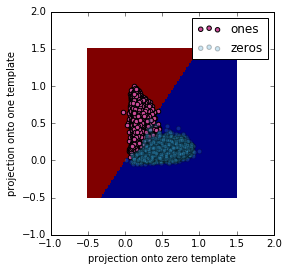

In [47]:
##test with
w = np.array([-1.5,1])
b = .01
_ = view_class(w, b)


plt.scatter(phi_s_ones[:,0], phi_s_ones[:,1],c=one_color,label='ones', alpha = 1)
plt.scatter(phi_s_zeros[:,0], phi_s_zeros[:,1],c=zero_color,label='zeros', alpha = 0.25)
plt.legend()
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel('projection onto zero template')
plt.ylabel('projection onto one template')

We can learn a lot about the quality of our hand-coded solution simply by inspecting the plot above. But we also need to quantify performance of the classifier. We'll use "percent correct" as our metric. For each point in our training set, we'll evaluate whether it is classified as a "0" ($y(\mathbf{x}) <0$) or a "1" ($y(\mathbf{x}) \geq 0$)

In [48]:
##a discriminant function
def discriminant_function(data,weight_vector,bias):
    '''
    discriminant_function(data,weight_vector,bias)
    data = N x 2
    weight_vector = N x 1 array
    bias = scalar
    returns y(x) = (w.dot(x)+b) > 0
    '''
    return (weight_vector.dot(data)+bias) >= 0

In [50]:
one_preds = discriminant_function(phi_s_ones.T, w,b)  ##true == correct
zero_preds = discriminant_function(phi_s_zeros.T, w,b)  ##false == correct

trn_one_correct = np.sum(one_preds==True)/float(len(one_preds))
trn_zero_correct = np.sum(zero_preds==False)/float(len(one_preds))

print 'percentage of correct ones, training set:  %0.2f' %(trn_one_correct)
print 'percentage of correct zeros: training_set: %0.2f' %(trn_zero_correct)
print 'total percent correct: %0.2f' %((trn_one_correct+trn_zero_correct)/2.)

percentage of correct ones, training set:  0.96
percentage of correct zeros: training_sets 0.88
total percent correct: 0.92


How well are we doing? Tweak "weight_vector" and "bias" to see if we can get something better...
Then, repeat the above calculations for the validation set.

### Brute force optimization
Since our parameter space is pretty small, we can try to optimize our model by simply iterating over some range of reasonable model parameter values, and then just picking the one with the best performance

In [80]:
num_steps = 100
w_1_range = np.linspace(-1,1,num=num_steps)
w_2_range = np.linspace(-1,1,num=num_steps)
bias_range = np.linspace(-1,1,num=num_steps)
b = 0.0
trn_performance = np.zeros([num_steps]*2)
for ii,w1 in enumerate(w_1_range):
    for jj,w2 in enumerate(w_2_range):
        w = np.array([w1,w2])
        one_preds = discriminant_function(phi_s_ones.T, w,b)  ##true == correct
        zero_preds = discriminant_function(phi_s_zeros.T, w,b)  ##false == correct
        trn_one_correct = np.sum(one_preds==True)/float(len(one_preds))
        trn_zero_correct = np.sum(zero_preds==False)/float(len(one_preds))
        trn_performance[ii,jj] = (trn_one_correct+trn_zero_correct)/2.
            

            

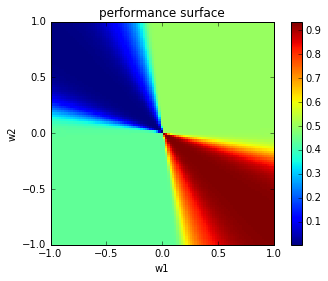

In [85]:
plt.pcolor(w_1_range,w_2_range,trn_performance)
plt.title('performance surface')
plt.colorbar()
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel('w1')
plt.ylabel('w2')

The solution with the best training peformance is probably the one you came up with via hand-coding.

In [82]:
best_idx = np.unravel_index(trn_performance.argmax(), trn_performance.shape)
best_solution = np.array((w_1_range[best_idx[0]],w_2_range[best_idx[1]]))
print 'best training performance: %0.2f' %(trn_performance[best_idx[0],best_idx[1]])
print 'corresponding solution: w = (%0.2f, %0.2f)' %(w_1_range[best_idx[0]],w_2_range[best_idx[1]])

best training performance: 0.94
corresponding solution: w = (-0.84, 1.00)


### Validation performance
So far, we've tested the performance on the training set. But to really know how our model is doing, we need to test it on a novel data set that the model was optimized on. This is known as the "validation" data set.

In [83]:

##project validation images onto templates to get feature space data
val_phi_s_ones = val_ones.reshape((n_val_ones,pixel_res**2)).dot(temps)
val_phi_s_zeros = val_zeros.reshape((n_val_zeros,pixel_res**2)).dot(temps)

one_preds = discriminant_function(val_phi_s_ones.T, best_solution,b)  ##true == correct
zero_preds = discriminant_function(val_phi_s_zeros.T, best_solution,b)  ##false == correct
val_one_correct = np.sum(one_preds==True)/float(len(one_preds))
val_zero_correct = np.sum(zero_preds==False)/float(len(one_preds))
validation_performance = (val_one_correct+val_zero_correct)/2.
print 'validation performance: %0.2f' %(validation_performance)

validation performance: 0.93


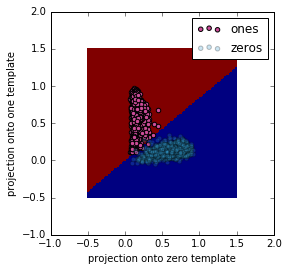

In [84]:
_ = view_class(best_solution, b)
plt.scatter(val_phi_s_ones[:,0], val_phi_s_ones[:,1],c=one_color,label='ones', alpha = 1)
plt.scatter(val_phi_s_zeros[:,0], val_phi_s_zeros[:,1],c=zero_color,label='zeros', alpha = 0.25)
plt.legend()
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel('projection onto zero template')
plt.ylabel('projection onto one template')

In this example, the model's performance on the validation is only slightly worse than the performance on the training data. That's only because this is a really easy toy problem.

#### Exercise
We constructed a feature space by using a randomly selected image of "1" and "0" as templates. 

Try to improve the performance of your DIY classifier via a more principled selection of templates.